In [1]:
import pandas as pd
import matplotlib as mp
import numpy as np
import datetime
import pprint
from math import sqrt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

cores = 4

%matplotlib inline

#Root de archivos de datos
root_dir = '../data/'
group=['ref_hash','window_nr']

---
## Read de Features

In [2]:
features = pd.read_csv('training_set.csv',low_memory=False).set_index(group)

In [3]:
features.reset_index().window_nr.value_counts()

3    322123
2    312181
1    298540
Name: window_nr, dtype: int64

In [4]:
new_features = features.groupby('ref_hash').mean()

In [5]:
new_features.head()

,auc_secs_to_next_mean,auc_secs_to_next_std,auc_secs_to_next_max,auc_secs_to_next_min,ins_secs_to_next_mean,ins_secs_to_next_std,ins_secs_to_next_max,ins_secs_to_next_min,eve_secs_to_next_mean,eve_secs_to_next_std,...,secs_since_last_event,wifi,timeToClick_mean,amount_dif_advertisers,amount_installs,last_event,before_last_event,before_before_last_event,kmeans20,kmeans50
ref_hash,,,,,,,,,,,,,,,,,,,,,
40621409780134,7894.000000,0.000000,0.0,0.000000,7005.000000,0.0,0.000000,0.000000,19642.000000,55367.000000,...,32304.000000,0.0,186.0,0.0,0.0,364.000000,7.0,363.000000,7.000000,48.000000
41863526108385,5760.333333,1479.333333,0.0,8639.333333,5488.666667,61.0,0.666667,106.666667,462.666667,3252.333333,...,127246.666667,0.0,194.0,0.0,1.0,1.666667,1.0,1.333333,5.666667,20.666667
69039685746313,8173.000000,0.000000,0.0,0.000000,8178.500000,0.0,0.000000,0.000000,3297.500000,8646.000000,...,12766.000000,1.0,192.0,0.0,0.0,151.000000,287.0,151.000000,16.000000,14.000000
90072729247980,8452.000000,0.000000,0.0,0.000000,9352.000000,0.0,0.000000,0.000000,12.000000,15.000000,...,192545.000000,0.0,198.0,0.0,0.0,0.000000,0.0,0.000000,18.000000,4.000000
135153013040192,114.000000,166.000000,1.0,480.000000,7632.000000,0.0,0.000000,0.000000,12489.000000,0.000000,...,0.000000,0.0,198.0,0.0,0.0,0.000000,0.0,0.000000,2.000000,14.000000


In [6]:
targets = pd.read_csv('targets.csv').set_index(group)

In [7]:
targets.isnull().sum()

target_st    0
target_sc    0
dtype: int64

In [8]:
training_set = features.merge(targets, how='inner', left_index=True,right_index=True)

In [9]:
training_set.head()

,,auc_secs_to_next_mean,auc_secs_to_next_std,auc_secs_to_next_max,auc_secs_to_next_min,ins_secs_to_next_mean,ins_secs_to_next_std,ins_secs_to_next_max,ins_secs_to_next_min,eve_secs_to_next_mean,eve_secs_to_next_std,...,timeToClick_mean,amount_dif_advertisers,amount_installs,last_event,before_last_event,before_before_last_event,kmeans20,kmeans50,target_st,target_sc
ref_hash,window_nr,,,,,,,,,,,,,,,,,,,,,
4881735474151208235,1,8033.0,0.0,0.0,0.0,7632.0,0.0,0.0,0.0,17.0,0.0,...,198.000,0.0,0.0,7.0,0.0,0.0,19,15,259200.0,259200.0
4679881814211948892,1,45.0,77.0,2.0,182.0,7632.0,0.0,0.0,0.0,12489.0,0.0,...,25.335,1.0,0.0,0.0,0.0,0.0,9,27,63602.0,259200.0
3122152074658312541,1,2102.0,8615.0,1.0,53265.0,7632.0,0.0,0.0,0.0,12489.0,0.0,...,198.000,0.0,0.0,0.0,0.0,0.0,6,5,2472.0,259200.0
3317753467203870649,1,8033.0,0.0,0.0,0.0,7632.0,0.0,0.0,0.0,70.0,0.0,...,198.000,0.0,0.0,15.0,0.0,0.0,19,15,259200.0,259200.0
4177895333092974918,1,3990.0,15394.0,0.0,59636.0,7632.0,0.0,0.0,0.0,12489.0,0.0,...,198.000,0.0,0.0,0.0,0.0,0.0,15,41,259200.0,259200.0


In [10]:
x_st = training_set[[x for x in training_set.columns if x not in targets.columns]]
y_st = training_set['target_st']

x_sc = training_set[[x for x in training_set.columns if x not in targets.columns]]
y_sc = training_set['target_sc']

---
## Training 

In [11]:
xtrain_st, xtest_st, ytrain_st, ytest_st = train_test_split(x_st, y_st, train_size=0.7)
xtrain_sc, xtest_sc, ytrain_sc, ytest_sc = train_test_split(x_sc, y_sc, train_size=0.7)

In [12]:
%%time

model_st = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=cores)
model_sc = xgb.XGBRegressor(objective='reg:squarederror', n_jobs = cores)

model_st.fit(xtrain_st, ytrain_st)
model_sc.fit(xtrain_sc, ytrain_sc)

/home/gatti2602/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


CPU times: user 1min 12s, sys: 635 ms, total: 1min 12s
Wall time: 20.3 s


In [13]:
def xgb_model_select(X, y):  
    print ('Select Model...')
    start_time  = datetime.datetime.now()
    xgb_clf = xgb.XGBRegressor() 
    parameters = {'objective':['reg:squarederror'],'n_estimators': [i for i in range(20,110,30)], 'max_depth':[i for i in range (3,6)]}
    grid_search = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=10, n_jobs=4, scoring='neg_mean_squared_error')
    print("parameters:")
    pprint.pprint(parameters)
    grid_search.fit(X, y)
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters=grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    end_time = datetime.datetime.now()
    print ('Select Done..., Time Cost: %d' % ((end_time - start_time).seconds) )

In [14]:
#xgb_model_select(x_sc,y_sc)

In [15]:
ypred_st = model_st.predict(xtest_st)
print("Error St.:", sqrt(mean_squared_error(ytest_st,ypred_st)))

ypred_sc = model_sc.predict(xtest_sc)
print("Error Sc.:", sqrt(mean_squared_error(ytest_sc,ypred_sc)))

Error St.: 83111.07837338508
Error Sc.: 52320.62888059935


Text(0.5, 1.0, 'Features Mas importantes para St')

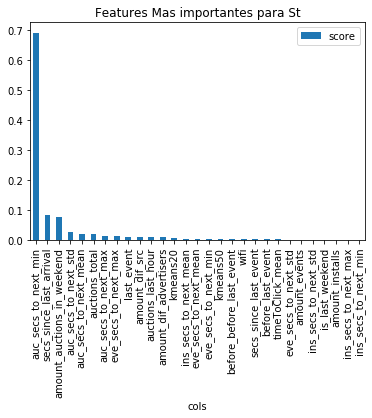

In [16]:
pd.DataFrame({'score':model_st.feature_importances_ , 'cols': x_st.columns})\
        .sort_values(by='score',ascending=False)\
        .plot(kind='bar', x='cols', y='score')\
        .set_title("Features Mas importantes para St")

Text(0.5, 1.0, 'Features Mas importantes para Sc')

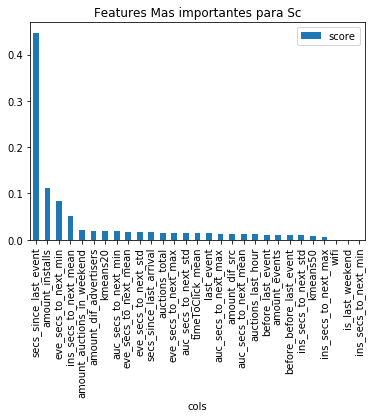

In [17]:
pd.DataFrame({'score':model_sc.feature_importances_ , 'cols': x_st.columns})\
        .sort_values(by='score',ascending=False)\
        .plot(kind='bar', x='cols', y='score')\
        .set_title("Features Mas importantes para Sc")

---
## Prediccion

In [18]:
# Labels a submitir con las predicciones

to_predict = pd.read_csv(root_dir + 'target_competencia_ids.csv',usecols=['ref_hash'])
to_predict.head()

,ref_hash
0,1000169251625791246_sc
1,1000169251625791246_st
2,1000395625957344683_sc
3,1000395625957344683_st
4,1003027494996471685_sc


In [19]:
X = new_features

In [20]:
xtrain_st.columns

Index(['auc_secs_to_next_mean', 'auc_secs_to_next_std', 'auc_secs_to_next_max',
       'auc_secs_to_next_min', 'ins_secs_to_next_mean', 'ins_secs_to_next_std',
       'ins_secs_to_next_max', 'ins_secs_to_next_min', 'eve_secs_to_next_mean',
       'eve_secs_to_next_std', 'eve_secs_to_next_max', 'eve_secs_to_next_min',
       'secs_since_last_arrival', 'auctions_total', 'auctions_last_hour',
       'amount_auctions_in_weekend', 'is_last_weekend', 'amount_dif_src',
       'amount_events', 'secs_since_last_event', 'wifi', 'timeToClick_mean',
       'amount_dif_advertisers', 'amount_installs', 'last_event',
       'before_last_event', 'before_before_last_event', 'kmeans20',
       'kmeans50'],
      dtype='object')

In [21]:
y_st = model_st.predict(X)
y_sc = model_sc.predict(X)

In [22]:
results_st = X.reset_index()['ref_hash'].transform(lambda x: str(x) + '_st').rename('ref_hash').to_frame()
results_st['obj'] = y_st

results_sc = X.reset_index()['ref_hash'].transform(lambda x: str(x) + '_sc').rename('ref_hash').to_frame()
results_sc['obj'] = y_sc

results = results_st.append(results_sc)

In [23]:
targets_mean = targets.reset_index()
targets_mean = targets_mean.loc[~targets_mean['ref_hash'].isin(X.reset_index()['ref_hash'])].groupby('ref_hash')[['target_st','target_sc']].mean().reset_index()

t_st = targets_mean['ref_hash'].transform(lambda x: str(x) + '_st').rename('ref_hash').to_frame()
t_st['obj'] = targets_mean['target_st']

t_sc = targets_mean['ref_hash'].transform(lambda x: str(x) + '_sc').rename('ref_hash').to_frame()
t_sc['obj'] = targets_mean['target_sc']

r = t_st.append(t_sc)

In [24]:
results = results.append(r)

In [25]:
to_predict.merge(results, on='ref_hash', how='left')['obj'].count()

8056

In [26]:
#Armado de File Final
max_secs = 3*24*60*60
to_predict.merge(results, on='ref_hash', how='left').fillna(max_secs).to_csv('predictions_xgb1.csv', header=True, index=False)

In [27]:
to_predict.count()

ref_hash    8074
dtype: int64